## Algorithmic Trading: Mean Reversion 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime
import back_testing as bt

### Import Libraries

### Store API Keys

In [18]:
#API Keys stored in alpha_vantage.txt file
API_KEY = open('alphavantage_api_keys.txt').read()

### Get Data

In [19]:
#Choose symbol
symbol = 'SQ'

#Get request
r = requests.get(f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize=full&apikey={API_KEY}').json()

In [20]:
#Data Cleaning
metadata = r['Meta Data']
df = pd.DataFrame(r['Time Series (Daily)'], dtype=float).transpose()

#Reverse index
df = df.reindex(index=df.index[::-1])
df.reset_index(level=0, inplace=True)

#Rename cols
df = df.rename({
    'index': 'date',
    '1. open': 'open',
    '2. high': 'high',
    '3. low': 'low',
    '4. close': 'close',
    '5. adjusted close': 'adjusted_close',
    '6. volume': 'volume',
    '7. dividend amount': 'dividend_amount',
    '8. split coefficient': 'split_coefficient'
},axis=1)

#Convert date col to datetime format
df['date'] = pd.to_datetime(df['date'])

In [21]:
df = df[((df['date'] >= pd.to_datetime('2019-01-01')) & (df['date'] <= pd.to_datetime('2021-06-01')))]

### Calculate ma

In [22]:
#Short moving averages (5-20 periods) are best suited for short-term trends and trading
df['ma_200'] = df['close'].rolling(200).mean()

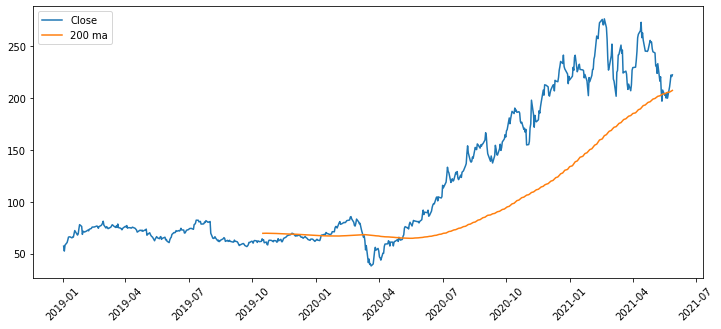

In [23]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(df['date'], df['close'], label = 'Close')
plt.plot(df['date'], df['ma_200'], label = '200 ma')

plt.legend()
plt.show()

### Calculate Bollinger Bands

In [24]:
period = 20

#Calculate 20-ma and std dev
df['ma_20'] = df['close'].rolling(period).mean()
df['std'] = df['close'].rolling(period).std()

#Calculate bollinger bands using std dev
df['upper_bollinger'] = df['ma_20'] + (2 * df['std'])
df['lower_bollinger'] = df['ma_20'] - (2 * df['std'])

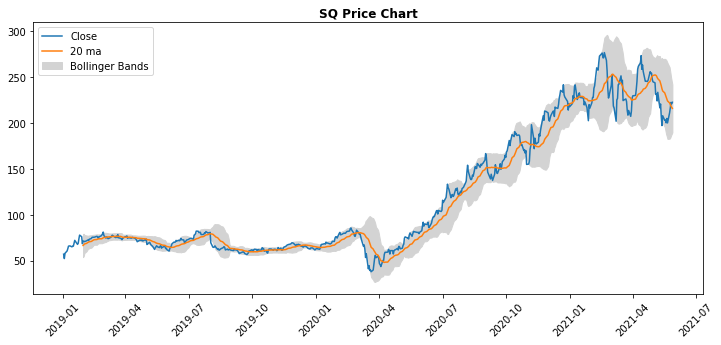

In [25]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df['date']

plt.plot(x_axis, df['close'], label = 'Close')
plt.plot(df['date'], df['ma_20'], label = '20 ma')
plt.fill_between(x_axis, df['upper_bollinger'], df['lower_bollinger'], label = 'Bollinger Bands', color='lightgrey')

plt.title('SQ Price Chart', fontweight="bold")
plt.legend()
plt.show()

### Calculate RSI

In [26]:
def gain(value):
    if value < 0:
        return 0
    else:
        return value

In [27]:
def loss(value):
    if value > 0:
        return 0
    else:
        return abs(value)

In [28]:
period = 6

#Calculate price delta
df['delta'] = df['close'].diff()

#Classify delta into gain & loss
df['gain'] = df['delta'].apply(lambda x:gain(x))
df['loss'] = df['delta'].apply(lambda x:loss(x))

#Calculate ema 
df['ema_gain'] = df['gain'].ewm(period).mean()
df['ema_loss'] = df['loss'].ewm(period).mean()

#Calculate RSI
df['rs'] = df['ema_gain']/df['ema_loss']
df['rsi'] = df['rs'].apply(lambda x: 100 - (100/(x+1)))

(0.0, 100.0)

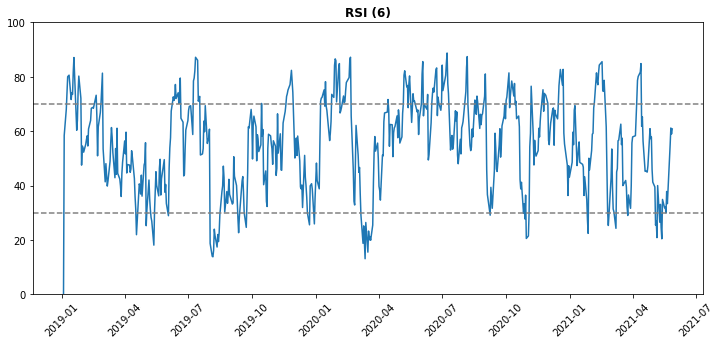

In [29]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df['date']

plt.plot(x_axis, df['rsi'])
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')

plt.title('RSI (6)', fontweight="bold")
plt.ylim([0, 100])

### Implementing buy/sell

#### Rules:
    1. Buy when 10-period RSI below 30 (buy next day) & Price below lower bollinger band
    2. Sell when 10-period RSI above 70 (sell next day) & Price above upper bollinger band

In [30]:
#buy signal
df['signal'] = np.where(
    (df['rsi'] < 30) &
    (df['close'] < df['lower_bollinger']), 1, np.nan)

#sell signal
df['signal'] = np.where(
    (df['rsi'] > 70) & 
    (df['close'] > df['upper_bollinger']), -1, df['signal'])

#buy/sell next trading day
df['signal'] = df['signal'].shift()
df['signal'] = df['signal'].fillna(0)

### Backtesting Strategy

In [31]:
bt.backtest_dataframe(df)

Evaluation Metrics:
-----------------------------------
Number of Trades: 7
Number of Gains: 6
Number of Losses: 1
Total Returns: 136.31%
Win Rate: 85.71%
Average Gain: 16.48%
Average Loss: -3.31%
Max Return: 30.71%
Max Loss: -3.31%



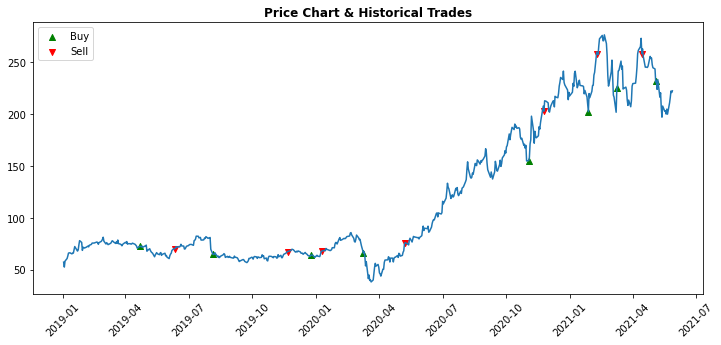

In [33]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(df['date'], df['close'])
plt.scatter(df[(df['signal'] == 1)]['buy_date'], df[(df['signal'] == 1)]['close'], label = 'Buy', marker='^', c='g')
plt.scatter(df[(df['signal'] == -1)]['sell_date'], df[(df['signal'] == -1)]['close'], label = 'Sell', marker='v', c='r')

plt.title('Price Chart & Historical Trades', fontweight="bold")
plt.legend()
plt.show()